In [1]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import glob,os,pdb
import datetime as dt
import pandas as pd
import scipy.stats
%matplotlib ipympl
plt.close('all')

In [2]:
def calculate_bad_pixels(mean_dark,std_dark,bp=None):
    dead = np.zeros(mean_dark.shape)
    hot = dead.copy()
    cold = dead.copy()
    high_std = dead.copy()
    if bp is None:
        bp = np.zeros(dead.shape)
    
    dead[
        np.logical_and(std_dark < 1,bp<1)
    ] = 1  # Dead Pixels
    dead[std_dark.mask] = 0
    
    cold[
        np.logical_and(mean_dark < 1000, std_dark < 1,bp<1)
    ] = 1  # COLD Pixels
    cold[std_dark.mask] = 0
    
    hot[
        np.logical_and(mean_dark > 3000, std_dark < 1,bp<1)
    ] = 1  # HOT Pixels
    hot[std_dark.mask] = 0
    
    high_std[
        np.logical_and(std_dark > 5 * np.nanmean(std_dark),bp<1)
    ] = 1
    high_std[std_dark.mask] = 0

    return {'dead':dead[:],'cold':cold[:],'hot':hot[:],'noisy':high_std[:]}


In [3]:
ch4_l0_files = list(Path('./2024/').rglob('*CH4*.nc'))
ch4_l0_files.extend(list(Path('./2025/').rglob('*CH4*.nc')))
ch4_l0_files = sorted(ch4_l0_files)
ch4_l0_files = np.array(ch4_l0_files)
ch4_l0_collect_id = np.array([str(fi).split('/')[-1].split('_')[5] for fi in ch4_l0_files])


o2_l0_files = list(Path('./2024/').rglob('*O2*.nc'))
o2_l0_files.extend(list(Path('./2025/').rglob('*O2*.nc')))
o2_l0_files = sorted(o2_l0_files)
o2_l0_files = np.array(o2_l0_files)
o2_l0_collect_id = np.array([str(fi).split('/')[-1].split('_')[5] for fi in o2_l0_files])


ch4_nframes = np.array([len(Dataset(fi).dimensions['frame_number']) for fi in ch4_l0_files])
o2_nframes = np.array([len(Dataset(fi).dimensions['frame_number']) for fi in o2_l0_files])


In [5]:
os.chdir('/media/sata/methanesat/darks/')
ch4_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_CH4_BadPixelMap_CH4_20250722.nc','r')['BadPixelMap'][:] 
o2_bp = Dataset('../level1a_calibration_MSAT_20250722.0.0_O2_BadPixelMap_O2_20250722.nc','r')['BadPixelMap'][:] 

## Count up bad pixels for each family

In [28]:
bp_types = ['cold','dead','hot','noisy']
o2 = {
    'masked':np.zeros(len(o2_l0_files)),
    'frame_masked':np.zeros((len(o2_l0_files))),
    'skew_low':np.zeros((len(o2_l0_files))),
    'skew_high':np.zeros((len(o2_l0_files))),
    'time':np.zeros((len(o2_l0_files)))
     }
o2['collect_id'] = [str(fi).split('/')[-1].split('_')[5] for fi in o2_l0_files]
o2['nframes'] = o2_nframes[:]
for tp in bp_types:
    o2[tp] = np.zeros((len(o2_l0_files),2,2048))

for ifi,fi in enumerate(o2_l0_files[:]):
    print(f'File {ifi}/{len(o2_l0_files)}: {fi}')
    with Dataset(fi,'r') as fid:
        o2['time'][ifi] = fid['Frame/TimeStamp'][:][-1]*1e-6 #secs after 1980-1-1
        dn = fid['Frame/PixelData'][:]
        mean = dn.mean(0)#fid['mean_dark'][:]
        std = dn.std(0)#fid['std_dark'][:]
        msk = dn.mask.sum(0)#fid['total_masked'][:]
        minim = dn.min(0)#fid['min_dn'][:]
        maxim = dn.max(0)#fid['max_dn'][:]
        med = np.nanmedian(dn,0)#fid['median_dn'][:]
        bp = calculate_bad_pixels(mean,std,bp=o2_bp)
        #np.save(f'bad_pixel_maps/o2/{str(fi).split("/")[-1][:-3]}_bp.npy',bp,allow_pickle=True)
        for tp in bp_types:
            o2[tp][ifi,0] = bp[tp].sum(1)
            o2[tp][ifi,1] = bp[tp].sum(0)
        o2['skew_low'][ifi] = np.sum(med < mean - std)
        o2['skew_high'][ifi] = np.sum(med > mean + std)
        o2['frame_masked'][ifi] = msk.sum()    
        o2['masked'][ifi] = mean.mask.sum()
o2['norm_ratio_masked'] = o2['frame_masked']/o2['masked']/o2['nframes']
np.save('o2_bp.pkl',o2,allow_pickle=True)

File 0/581: 2024/06/14/00430001/po-1982/MethaneSAT_L0_O2_Dark_0_00430001.nc


/tmp/ipykernel_3821771/2454076175.py:24: RuntimeWarning: All-NaN slice encountered
  med = np.nanmedian(dn,0)#fid['median_dn'][:]


File 1/581: 2024/06/15/00530001/202407311706/MethaneSAT_L0_O2_Dark_0_00530001.nc
File 2/581: 2024/06/21/00680001/po-1991/MethaneSAT_L0_O2_Dark_0_00680001.nc
File 3/581: 2024/06/21/00690001/po-1991/MethaneSAT_L0_O2_Dark_0_00690001.nc
File 4/581: 2024/06/21/006A0001/po-1991/MethaneSAT_L0_O2_Dark_0_006A0001.nc
File 5/581: 2024/06/22/00780001/po-2017/MethaneSAT_L0_O2_Dark_0_00780001.nc
File 6/581: 2024/06/22/00790001/po-2073/MethaneSAT_L0_O2_Dark_0_00790001.nc
File 7/581: 2024/07/19/00A30001/po-2065/MethaneSAT_L0_O2_Dark_0_00A30001.nc
File 8/581: 2024/07/19/00A30001/po-2067/MethaneSAT_L0_O2_Dark_0_00A30001.nc
File 9/581: 2024/07/19/00A40001/po-2065/MethaneSAT_L0_O2_Dark_0_00A40001.nc
File 10/581: 2024/07/19/00A40001/po-2067/MethaneSAT_L0_O2_Dark_0_00A40001.nc
File 11/581: 2024/07/19/00A50001/po-2065/MethaneSAT_L0_O2_Dark_0_00A50001.nc
File 12/581: 2024/07/19/00A50001/po-2067/MethaneSAT_L0_O2_Dark_0_00A50001.nc
File 13/581: 2024/07/19/00A60001/po-2065/MethaneSAT_L0_O2_Dark_0_00A60001.nc
Fil

In [29]:
ch4 = {
    'masked':np.zeros(len(ch4_l0_files)),
    'frame_masked':np.zeros((len(ch4_l0_files))),
    'skew_low':np.zeros((len(ch4_l0_files))),
    'skew_high':np.zeros((len(ch4_l0_files)))
     }
ch4['collect_id'] = [str(fi).split('/')[-1].split('_')[5] for fi in ch4_l0_files]
ch4['nframes'] = ch4_nframes[:]

for tp in bp_types:
    ch4[tp] = np.zeros((len(ch4_l0_files),2,2048))
    
for ifi,fi in enumerate(ch4_l0_files):
    print(f'File {ifi}/{len(ch4_l0_files)}: {fi}')
    with Dataset(fi,'r') as fid:
        ch4['time'][ifi] = fid['Frame/TimeStamp'][:][-1]*1e-6 #secs after 1980-1-1
        mean = fid['mean_dark'][:]
        std = fid['std_dark'][:]
        msk = fid['total_masked'][:]
        minim = fid['min_dn'][:]
        maxim = fid['max_dn'][:]
        med = fid['median_dn'][:]
        bp = calculate_bad_pixels(mean,std,bp=ch4_bp)
        #np.save(f'bad_pixel_maps/ch4/{str(fi).split("/")[-1][:-3]}_bp.npy',bp,allow_pickle=True)
        for tp in bp_types:
            ch4[tp][ifi,0] = bp[tp].sum(1) #sum across columns
            ch4[tp][ifi,1] = bp[tp].sum(0) #sum down rows
        ch4['frame_masked'][ifi] = msk.sum()
        ch4['masked'][ifi] = mean.mask.sum()
        ch4['skew_low'][ifi] = np.sum(med < mean - std)
        ch4['skew_high'][ifi] = np.sum(med > mean + std)
ch4['norm_ratio_masked'] = ch4['frame_masked']/ch4['masked']/ch4['nframes']
np.save('ch4_bp.pkl',ch4,allow_pickle=True)

File 0/580: 2024/06/14/00430001/po-1982/MethaneSAT_L0_CH4_Dark_0_00430001.nc


KeyError: 'time'

## Compute and save out of family collects

In [6]:
bp_types = ['cold','dead','hot','noisy']
o2 = np.load('o2_bp.pkl.npy',allow_pickle=True).item()
for tp in bp_types:
    o2[tp+'_total'] = o2[tp][:,0].sum(1)
    
o2_noisy_med = np.median(o2['noisy_total'])
o2_iqr = scipy.stats.scoreatpercentile(o2['noisy_total'],75)-scipy.stats.scoreatpercentile(o2['noisy_total'],25)

noisy_o2_inds = np.array(np.where(np.abs(o2['noisy_total']-o2_noisy_med) > 5*67./50.*o2_iqr)).flatten()
noisy_o2_files = o2_l0_files[noisy_o2_inds]
noisy_o2_total = o2['noisy_total'][noisy_o2_inds]
noisy_o2_collects = np.array([str(fi).split('/')[-1].split('_')[5].split('.')[0] for fi in noisy_o2_files])
with open('noisy_o2_id','w') as f:
    for c in noisy_o2_files:
        f.write(str(c)+'\n')

In [7]:
ch4 = np.load('ch4_bp.pkl.npy',allow_pickle=True).item()
for tp in bp_types:
    ch4[tp+'_total'] = ch4[tp][:,0].sum(1)
ch4_noisy_med = np.median(ch4['noisy_total'])
ch4_iqr = scipy.stats.scoreatpercentile(ch4['noisy_total'],75)-scipy.stats.scoreatpercentile(ch4['noisy_total'],25)

noisy_ch4_inds = np.array(np.where(np.abs(ch4['noisy_total']-ch4_noisy_med) > 5*67./50*ch4_iqr)).flatten()
noisy_ch4_files = ch4_l0_files[noisy_ch4_inds]
noisy_ch4_total = ch4['noisy_total'][noisy_ch4_inds]
noisy_ch4_collects = np.array([str(fi).split('/')[-1].split('_')[5].split('.')[0] for fi in noisy_ch4_files])
with open('noisy_ch4_id','w') as f:
    for c in noisy_ch4_files:
        f.write(str(c)+'\n')
    

In [8]:
ch4['date'] = np.array([dt.datetime(1980,1,1) + dt.timedelta(seconds=ti) for ti in ch4['time']])
ch4_df = pd.DataFrame({'date':ch4['date']},index=ch4['date'])
for tp in bp_types:
    ch4_df[tp] = ch4[f'{tp}_total'][:]
ch4_df['masked'] = ch4['masked'][:]
ch4_df['frame_masked'] = ch4['frame_masked'][:]

o2['date'] = np.array([dt.datetime(1980,1,1) + dt.timedelta(seconds=ti) for ti in o2['time']])
o2_df = pd.DataFrame({'date':o2['date']},index=o2['date'])
for tp in bp_types:
    o2_df[tp] = o2[f'{tp}_total'][:]
o2_df['masked'] = o2['masked'][:]
o2_df['frame_masked'] = o2['frame_masked'][:]

ch4_df['nframesx100'] = ch4_nframes*100
o2_df['nframesx100'] = o2_nframes*100

Text(0.5, 1.0, 'CH4 Bad Pixel Counts')

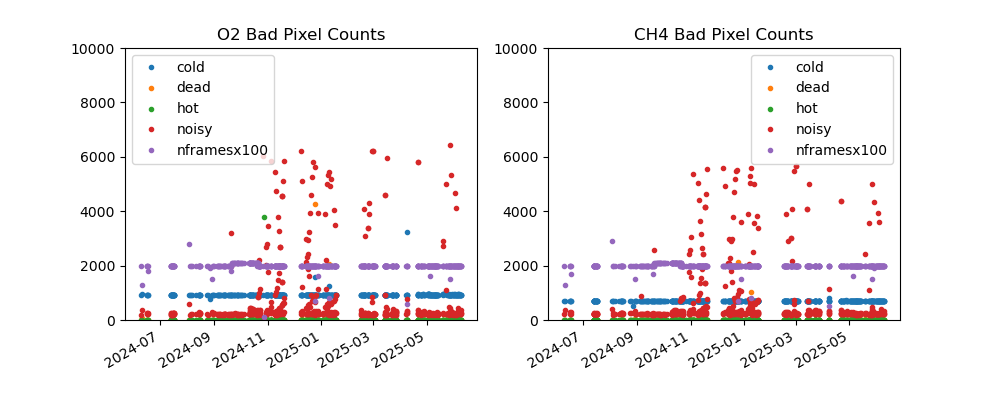

In [9]:
plt.close('all')
fig,axs = plt.subplots(1,2,figsize=(10,4))

ax = axs[0]
for ky in bp_types:
    o2_df[f'{ky}'].plot(ax=ax,linestyle='',marker='.')
o2_df['nframesx100'].plot(ax=ax,linestyle='',marker='.')
ax.set_ylim([0,10000])
ax.legend()
ax.set_title('O2 Bad Pixel Counts')

ax = axs[1]
for ky in bp_types:
    ch4_df[f'{ky}'].plot(ax=ax,linestyle='',marker='.')
ch4_df['nframesx100'].plot(ax=ax,linestyle='',marker='.')
ax.set_ylim([0,10000])
ax.legend()
ax.set_title('CH4 Bad Pixel Counts')



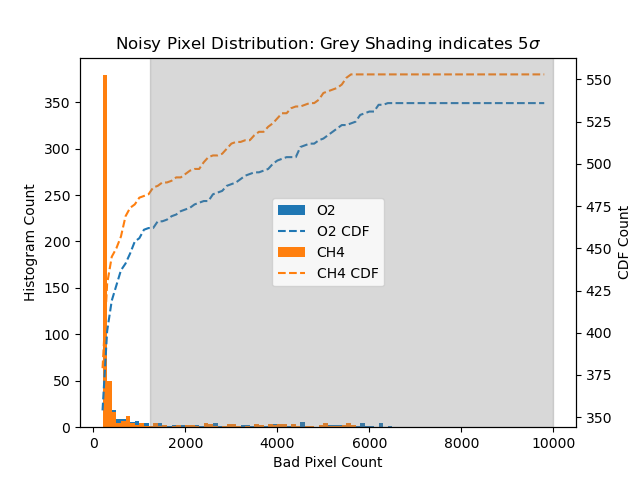

In [10]:
plt.close('all'); 
fig,ax = plt.subplots(1); 

g1 = ax.hist(o2['noisy_total'],bins=np.arange(200,10000,100))
g3 = ax.hist(ch4['noisy_total'],bins=np.arange(200,10000,100))
ax2 = ax.twinx()
g2 = ax2.plot(g1[1][:-1],g1[0].cumsum(),color='tab:blue',linestyle='--')
g4 = ax2.plot(g3[1][:-1],g3[0].cumsum(),color='tab:orange',linestyle='--')
ax2.axvspan(o2_noisy_med+5*67./50.*o2_iqr,10000,ymin=0,ymax=600,color='grey',alpha=0.3,zorder=2)
ax.set_ylabel('Histogram Count')
ax.set_xlabel('Bad Pixel Count')
ax2.set_ylabel('CDF Count');
ax.set_title('Noisy Pixel Distribution: Grey Shading indicates 5$\sigma$');
ax2.legend([g1[-1],g2[0],g3[-1],g4[0]],['O2','O2 CDF','CH4','CH4 CDF'],loc='center',facecolor='w');


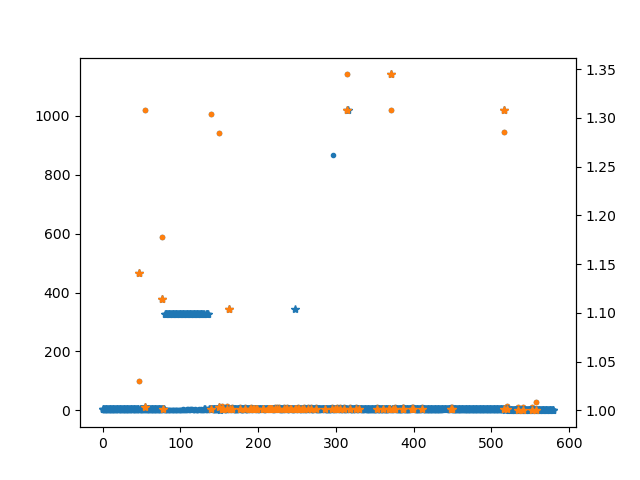

In [34]:
plt.close('all'); plt.figure(); plt.plot(o2['noisy'][:,0,:].max(1),'.');
plt.plot(noisy_o2_inds,o2['noisy'][noisy_o2_inds,0,:].max(1),'.');
plt.gca().twinx()
plt.plot(o2['frame_masked']/o2['masked']/o2['nframes'],'*')
plt.plot(noisy_o2_inds,o2['frame_masked'][noisy_o2_inds]/o2['masked'][noisy_o2_inds]/o2['nframes'][noisy_o2_inds],'*')


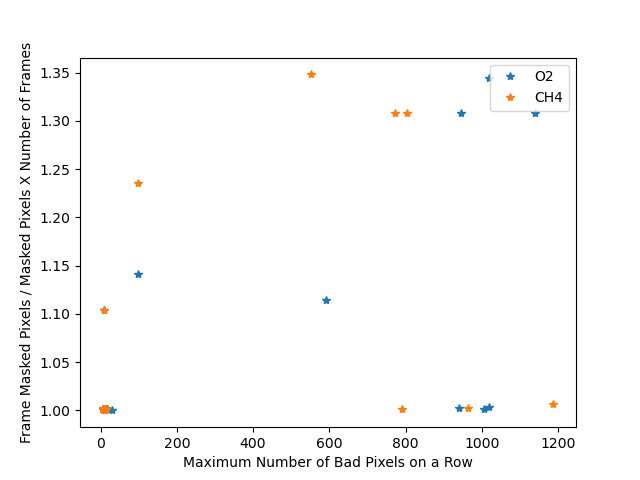

In [11]:
plt.close('all'); plt.figure();
plt.plot(o2['noisy'][noisy_o2_inds,0,:].max(1),o2['frame_masked'][noisy_o2_inds]/o2['masked'][noisy_o2_inds]/o2['nframes'][noisy_o2_inds],'*')
plt.plot(ch4['noisy'][noisy_ch4_inds,0,:].max(1),ch4['frame_masked'][noisy_ch4_inds]/ch4['masked'][noisy_ch4_inds]/ch4['nframes'][noisy_ch4_inds],'*')
plt.xlabel('Maximum Number of Bad Pixels on a Row')
plt.ylabel('Frame Masked Pixels / Masked Pixels X Number of Frames')
plt.legend(['O2','CH4'])

In [14]:
ch4_sort_inds = np.array(np.argsort(noisy_ch4_total))
o2_sort_inds = np.array(np.argsort(noisy_o2_total))
print('CH4 Noisy Files Highest to Lowest')
for i in ch4_sort_inds[-1::-1][:10]:
    print(f'{noisy_ch4_total[i]}: {noisy_ch4_files[i]}')
print('=====================================')
print('O2 Noisy Files Highest to Lowest')
for i in o2_sort_inds[-1::-1][:10]:
    print(f'{noisy_o2_total[i]}: {noisy_o2_files[i]}')


CH4 Noisy Files Highest to Lowest
142227.0: 2024/09/01/00F20001/po-2075/MethaneSAT_L0_CH4_Dark_0_00F20001.nc
21534.0: 2024/11/01/037C0001/202411052049_po-2207/MethaneSAT_L0_CH4_Dark_0_037C0001.nc
13201.0: 2024/10/27/034E0001/202411022044_po-2197/MethaneSAT_L0_CH4_Dark_0_034E0001.nc
12018.0: 2024/09/12/014A0001/202409171319_po-2103/MethaneSAT_L0_CH4_Dark_0_014A0001.nc
5650.0: 2025/03/06/080F0001/202503091957_po-2435/MethaneSAT_L0_CH4_Dark_0_080F0001.nc
5650.0: 2025/03/06/080F0001/202503101733_po-2435/MethaneSAT_L0_CH4_Dark_0_080F0001.nc
5590.0: 2024/12/13/04A40001/202412162103_po-2260/MethaneSAT_L0_CH4_Dark_0_04A40001.nc
5584.0: 2025/01/14/06400001/202501162058_po-2321/MethaneSAT_L0_CH4_Dark_0_06400001.nc
5541.0: 2024/11/24/04900001/202411272202_po-2251/MethaneSAT_L0_CH4_Dark_0_04900001.nc
5516.0: 2024/12/29/056F0001/202412312136_po-2276/MethaneSAT_L0_CH4_Dark_0_056F0001.nc
O2 Noisy Files Highest to Lowest
141856.0: 2024/09/01/00F20001/po-2075/MethaneSAT_L0_O2_Dark_0_00F20001.nc
24116.0

In [15]:
ch4_noisy_df = ch4_df.iloc[noisy_ch4_inds]
o2_noisy_df = o2_df.iloc[noisy_o2_inds]


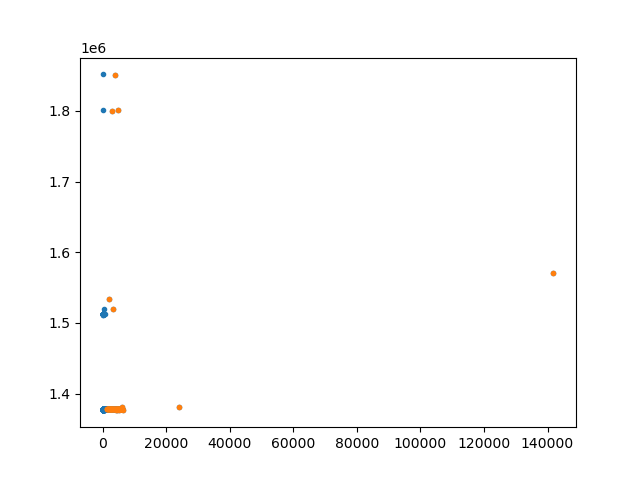

In [16]:
plt.figure(); 
plt.plot(o2['noisy_total'],o2['frame_masked']/o2['nframes'],'.')
plt.plot(o2['noisy_total'][noisy_o2_inds],o2['frame_masked'][noisy_o2_inds]/o2['nframes'][noisy_o2_inds],'.')


In [25]:
def denoise(dn=None,thresh=1.5,pf_bp=None):
    bp_c = calculate_bad_pixels(dn.mean(0),dn.std(0),bp=pf_bp)#np.load('bad_pixel_maps/ch4/MethaneSAT_L0_CH4_Dark_0_04A40001_mean_bp.npy',allow_pickle=True).item()
    noisy_inds = np.where(bp_c['noisy'] == 1)
    noisy_dn = np.array([dn[:,noisy_inds[0][i],noisy_inds[1][i]] for i in range(len(noisy_inds[0]))])
    noisy_dn_mean = noisy_dn.mean(1)
    noisy_dn_median = np.nanmedian(noisy_dn,1)
    noisy_dn_iqr = scipy.stats.iqr(noisy_dn,axis=1)
    noisy_dn_std = noisy_dn.std(1)
    
    #noisy_dn_filter = np.array([noisy_dn[i,:] > noisy_dn_mean[i]+thresh*noisy_dn_std[i] for i in range(len(noisy_dn_mean))])
    noisy_dn_filter = np.array([noisy_dn[i,:] > noisy_dn_median[i]+thresh*noisy_dn_iqr[i] for i in range(len(noisy_dn_median))])

    denoised_dark = dn[:]
    for i in range(len(noisy_inds[0])):
        denoised_dark[:,noisy_inds[0][i],noisy_inds[1][i]].mask = np.logical_or(noisy_dn_filter[i,:],dn[:,noisy_inds[0][i],noisy_inds[1][i]].mask)
    denoised_dark_mean = denoised_dark.mean(0)
    denoised_dark_std = denoised_dark.std(0)
    new_bp = calculate_bad_pixels(denoised_dark_mean,denoised_dark_std,bp=pf_bp)
    return bp_c,new_bp,denoised_dark,noisy_dn

0 03BA0001


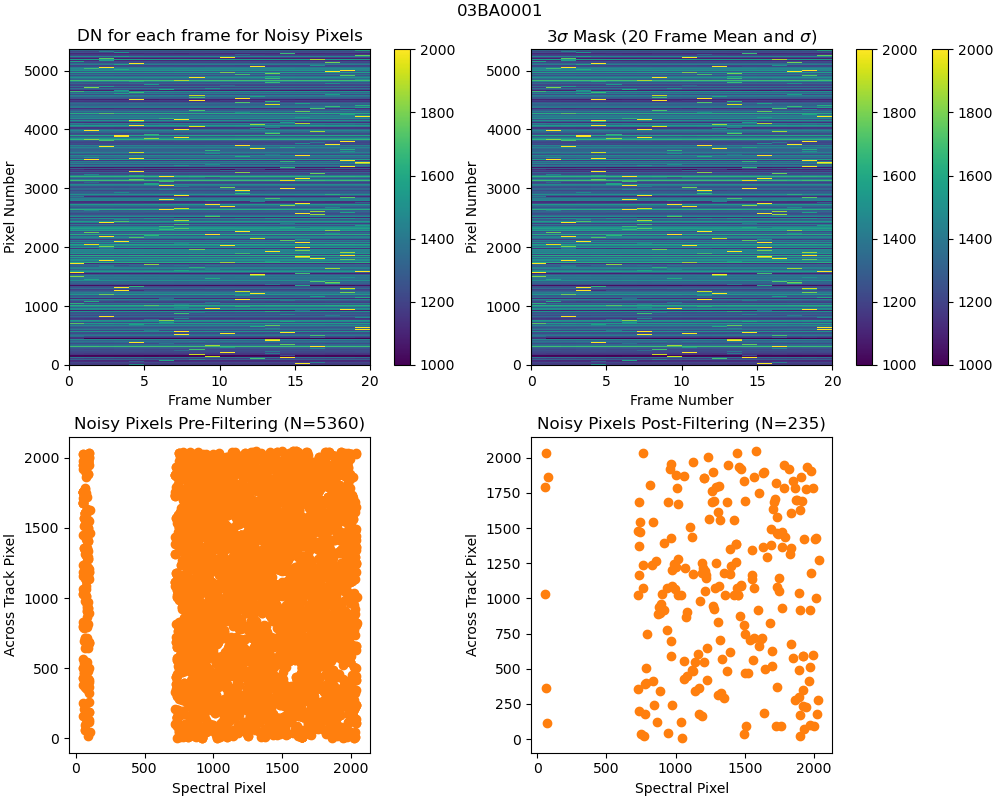

In [76]:

for ifi,fname in enumerate(noisy_ch4_files[10:11]):
    collect_id = str(fname).split('/')[3]
    print(f'{ifi} {collect_id}')
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp,denoised_dn = denoise(dn,pf_bp=ch4_bp)
    noisy_inds = np.where(bp_c['noisy'] == 1)
    noisy_dn = np.array([dn[:,noisy_inds[0][i],noisy_inds[1][i]] for i in range(len(noisy_inds[0]))])
    noisy_denoised_dn = np.array([denoised_dn[:,noisy_inds[0][i],noisy_inds[1][i]] for i in range(len(noisy_inds[0]))])
    
    plt.close('all')
    fig,axs = plt.subplots(2,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    g = ax.pcolormesh(noisy_dn,vmin=1000,vmax=2000); plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
#    g = ax.pcolormesh(noisy_dn_filter[:]);
#    g = ax.pcolormesh(np.logical_and(dn.mask,denoised_dn.mask).sum(0));
    g = ax.pcolormesh(noisy_denoised_dn,vmin=1000,vmax=2000); plt.colorbar(g,ax=ax)
    plt.colorbar(g,ax=ax)
    ax.set_title('3$\sigma$ Mask (20 Frame Mean and $\sigma$)')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Pre-Filtering (N={int(bp_c["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[1,1]
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Post-Filtering (N={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    fig.suptitle(collect_id)
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/ch4/ch4_{collect_id}_noisy_panel.png')



In [70]:
new_dn.mask.sum(0)

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]])

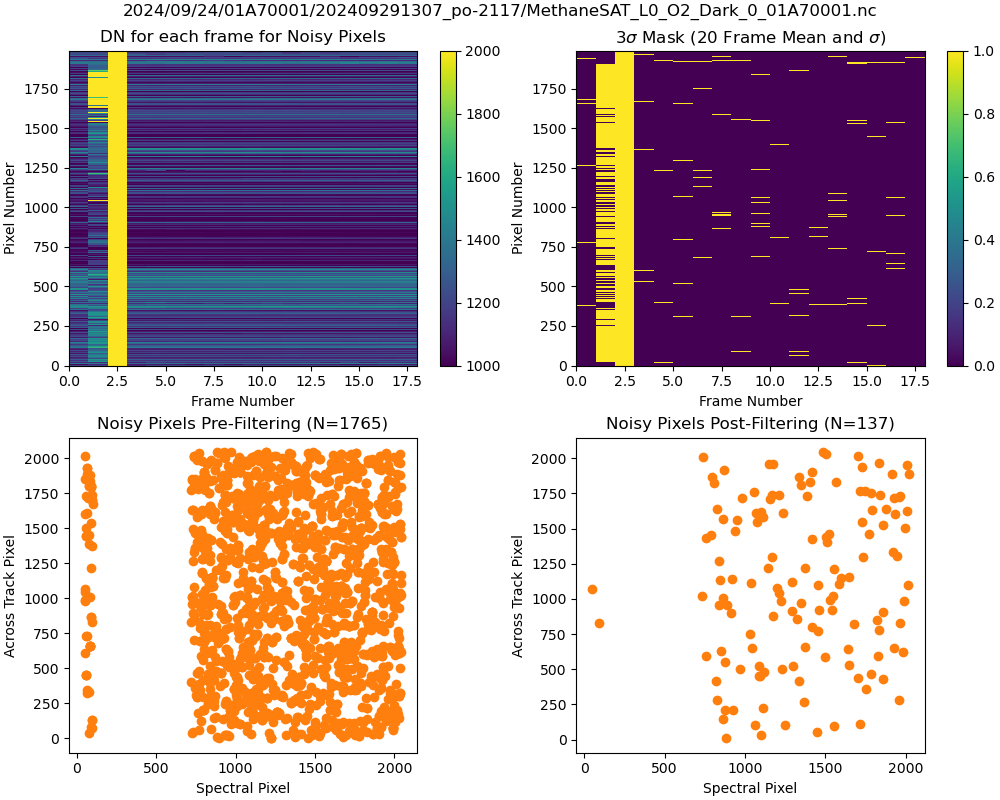

In [54]:
for fname in noisy_o2_files[10:11]:
    collect_id = str(fname).split('/')[3]
    dn = Dataset(fname)['Frame/PixelData'][:]
    bp_c,new_bp = denoise(dn,pf_bp=o2_bp)
    
    plt.close('all')
    fig,axs = plt.subplots(2,2,figsize=(10,8),layout='constrained')
    ax = axs[0,0]
    g = ax.pcolormesh(noisy_dn,vmin=1000,vmax=2000); plt.colorbar(g,ax=ax)
    ax.set_title('DN for each frame for Noisy Pixels')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[0,1]
    g = ax.pcolormesh(noisy_dn_filter[:]);
    plt.colorbar(g,ax=ax)
    ax.set_title('3$\sigma$ Mask (20 Frame Mean and $\sigma$)')
    ax.set_ylabel('Pixel Number')
    ax.set_xlabel('Frame Number')

    ax = axs[1,0]
    y,x = np.where(bp_c['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Pre-Filtering (N={int(bp_c["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    ax = axs[1,1]
    y,x = np.where(new_bp['noisy'])
    g = ax.scatter(x,y,c='tab:orange');
    ax.set_title(f'Noisy Pixels Post-Filtering (N={int(new_bp["noisy"].sum())})')
    ax.set_ylabel('Across Track Pixel')
    ax.set_xlabel('Spectral Pixel')

    fig.suptitle(fi)
    fig.savefig(f'figs/bad_pixel_maps/outlier_drops/o2/o2_{collect_id}_noisy_panel.png')



In [55]:
o2_bp_noisy_total = np.zeros((len(noisy_o2_files),2))
for ifi,fi in enumerate(noisy_o2_files):
    dn = Dataset(fi,'r')['Frame/PixelData'][:]
    bp_c,new_bp = denoise(dn,pf_bp=o2_bp)
    o2_bp_noisy_total[ifi,0] = bp_c['noisy'].sum()
    o2_bp_noisy_total[ifi,1] = new_bp['noisy'].sum()
    print(f'O2 {ifi} {fi}: Pre:{bp_c["noisy"].sum()} Post:{new_bp["noisy"].sum()}')
print('done!')

O2 2024/09/01/00F20001/po-2075/MethaneSAT_L0_O2_Dark_0_00F20001.nc: Pre:141856.0 Post:108153.0
O2 2024/09/10/01350001/202409121318_po-2092/MethaneSAT_L0_O2_Dark_0_01350001.nc: Pre:24117.0 Post:5466.0
O2 2024/09/24/01A70001/202409291307_po-2117/MethaneSAT_L0_O2_Dark_0_01A70001.nc: Pre:1990.0 Post:598.0
O2 2024/09/25/01B20001/202409281317_po-2116/MethaneSAT_L0_O2_Dark_0_01B20001.nc: Pre:3188.0 Post:163.0
O2 2024/10/27/034E0001/202411022044_po-2197/MethaneSAT_L0_O2_Dark_0_034E0001.nc: Pre:2199.0 Post:712.0
O2 2024/11/01/037C0001/202411052049_po-2207/MethaneSAT_L0_O2_Dark_0_037C0001.nc: Pre:6038.0 Post:1859.0
O2 2024/11/04/03850001/202411052049_po-2207/MethaneSAT_L0_O2_Dark_0_03850001.nc: Pre:2034.0 Post:147.0
O2 2024/11/04/03860001/202411052049_po-2207/MethaneSAT_L0_O2_Dark_0_03860001.nc: Pre:2694.0 Post:155.0
O2 2024/11/05/03980001/202411062059_po-2208/MethaneSAT_L0_O2_Dark_0_03980001.nc: Pre:2809.0 Post:181.0
O2 2024/11/06/03A90001/202411101414_po-2221/MethaneSAT_L0_O2_Dark_0_03A90001.n

In [ ]:
ch4_bp_noisy_total = np.zeros((len(noisy_ch4_files),2))
for ifi,fi in enumerate(noisy_ch4_files):
    dn = Dataset(fi,'r')['Frame/PixelData'][:]
    bp_c,new_bp = denoise(dn,pf_bp=ch4_bp)
    ch4_bp_noisy_total[ifi,0] = bp_c['noisy'].sum()
    ch4_bp_noisy_total[ifi,1] = new_bp['noisy'].sum()
    print(f'{ifi:4d} CH4 {str(fi).split("/")[3]}: Pre:{bp_c["noisy"].sum()} Post:{new_bp["noisy"].sum()}')
print('done!')

Text(0.5, 1.0, 'Relative Number of Noisy Pixels Removed by Filter')

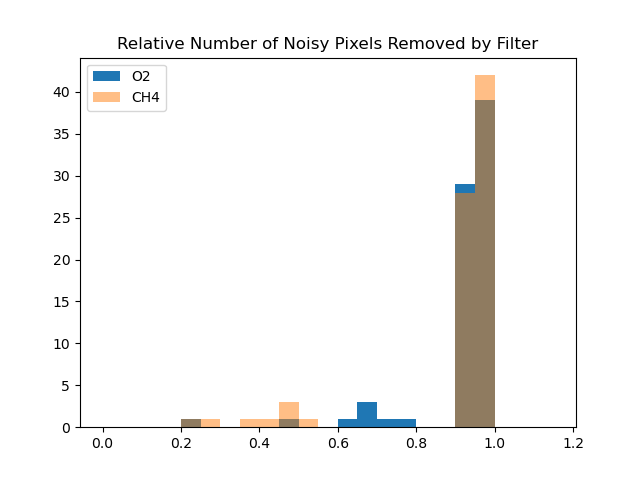

In [66]:
plt.close('all');
plt.figure()
plt.hist(1-o2_bp_noisy_total[:,1]/o2_bp_noisy_total[:,0],bins=np.arange(0,1.2,0.05))
plt.hist(1-ch4_bp_noisy_total[:,1]/ch4_bp_noisy_total[:,0],bins=np.arange(0,1.2,0.05),alpha=0.5)
plt.legend(['O2','CH4'])
plt.title('Relative Number of Noisy Pixels Removed by Filter')
